# ACNets: Connectivity Classifier

This notebook fits a binary classifier to predict participant's group, AVGP or NVGP, using Cognitive Control network connectivity matrices. As input, it receives upper-triangular connectivity matrices for each participant. Results are evaluated using 5-fold cross-validated f1 on the train set.

## 0. Setup

In [75]:

import numpy as np
import xarray as xr
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns; sns.set('poster')
import plotly.express as px

from sklearn import preprocessing, model_selection, metrics, ensemble, multioutput
from sklearn import decomposition, cross_decomposition, feature_selection, dummy, svm

from sklearn.pipeline import Pipeline
# from xgboost import XGBClassifier  # incompatible with umap's scipy

sns.set(style='dark')

# Technical reproducibility
%reload_ext watermark
%watermark -iv -co -ituhmv

Last updated: 2022-02-16T10:21:16.234304+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

matplotlib: 3.5.1
sklearn   : 1.0.2
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]
xarray    : 0.21.1
seaborn   : 0.11.2
numpy     : 1.21.5
plotly    : 5.5.0
pandas    : 1.4.0



### Load the dataset

In [156]:
atlases = ['dosenbach2007', 'difumo_64_2', 'difumo_128_2', 'difumo_1024_2']


DATASETS = dict()

for atlas in atlases:
  DATASETS[atlas] = xr.open_dataset(f'data/julia2018_resting/connectivity_{atlas}.nc')

# selected data for the analysis
ATLAS = 'difumo_64_2'
DATASET = DATASETS[ATLAS]
CONNECTIVITY = DATASET['tangent_connectivity'].values

## 1. Data

In [202]:
# 1. input (vectorized connectivity matrix)
X = np.array([subj_conn[np.triu_indices_from(subj_conn)] for subj_conn in CONNECTIVITY])

# 1.1. threshold X
X_threshold = np.median(X, axis=1) + np.std(X, axis=1)
X = np.where(np.abs(X) >= X_threshold.reshape(-1,1), X, 0)

# 2. output (AVGP vs NVGP encoded as integers)
y_encoder = preprocessing.LabelEncoder()
y = y_encoder.fit_transform(DATASET['group'])

# 2.1. behavioral outputs (inverse efficiency scores in millis)
y_beh = DATASET['inverse_efficiency_score_ms'].values

# 3. remove subjects with missing behavioral data
X = X[~np.isnan(y_beh)]
y = y[~np.isnan(y_beh)]
y_beh = y_beh[~np.isnan(y_beh)]

# DEBUG
print(f'{X.shape[0]} features, {X.shape[0]} subjects, {np.unique(y).shape[0]} class labels.')

32 features, 32 subjects, 2 class labels.


## Classification

-[ ] TODO: replicate https://www.frontiersin.org/articles/10.3389/fnhum.2014.00425/full

In [242]:
# ALT1: boosting 
model = svm.SVC(kernel='rbf', C=1, probability=True)
# model =ensemble.AdaBoostClassifier(model, n_estimators=100, algorithm='SAMME.R')

# ALT2: chance level
# model = dummy.DummyClassifier(strategy='uniform')

# ALT3: multi-output (classification + behavioral regression)
# model = multioutput.MultiOutputClassifier(ensemble.GradientBoostingClassifier())


pipeline = Pipeline([
    ('zerovar', feature_selection.VarianceThreshold()),
    # ('select', feature_selection.SelectKBest()),
    # ('rfe', feature_selection.RFE(svc)),
    # ('standard_scaler', preprocessing.StandardScaler()), 
    # ('reducer', UMAP(n_components=3)), 
    # ('reducer', decomposition.PCA()),
    # ('reducer', cross_decomposition.PLSCanonical()),    
    ('model', model),
], verbose=True)


param_grid = {
    # 'zerovar__threshold': [0],
    # 'select__k': np.linspace(1, X.shape[1], num=100, endpoint=True, dtype='int'),
    # 'rfe__n_features_to_select': [.1, .2, .5, 1.],
    # 'reducer__n_neighbors': [1, 2, 3, 4, 5, 10],  # UMAP
    # 'reducer__n_components': [2,3,5],  # UMAP
    # 'reducer__n_components': range(1, 30),  # PCA
    # 'model__n_estimators': [10, 100, 1000],  # XGBClassifier, GradientBoostingClassifier
    # 'model__estimator__n_estimators': [10, 100],  # MultiOutputClassifier
}

grid = model_selection.GridSearchCV(
    pipeline, param_grid,
    cv=model_selection.LeaveOneOut(),
    scoring='accuracy',
    # scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'], refit='accuracy',
    n_jobs=1, verbose=1,
)

# rfe_model = feature_selection.RFECV(grid)
# rfe_model.fit()

In [243]:
train, test = model_selection.train_test_split(
  range(len(X)),
  test_size=0.2,
  shuffle=True,
  stratify=y)

# fit
grid.fit(X[train], y[train])

# evaluate
score_train = grid.score(X[train], y[train])
score_test = grid.score(X[test], y[test])

# report scores and hyperparameters
print(f'Train set score (roc_auc): {score_train:.2f}')
print(f'Test set score (roc_auc): {score_test}')

Fitting 25 folds for each of 1 candidates, totalling 25 fits
[Pipeline] ........... (step 1 of 2) Processing zerovar, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing zerovar, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing zerovar, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing zerovar, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing zerovar, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing zerovar, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing zerovar, total=   0.0s
[Pipeline] .....

## Evaluate the model
Below is the confusion matrix of the classifier on the train and test sets.

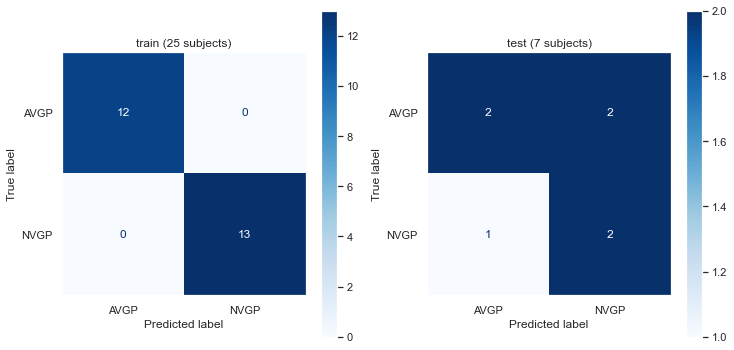

In [244]:
# plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# train set
metrics.ConfusionMatrixDisplay.from_estimator(
  grid,
  X[train], y[train],
  # normalize='all',
  display_labels=y_encoder.classes_,
  ax=axes[0],
  cmap='Blues'
  )

# test set
metrics.ConfusionMatrixDisplay.from_estimator(
  grid,
  X[test], y[test],
  # normalize='all',
  display_labels=y_encoder.classes_,
  ax=axes[1],
  cmap='Blues'
  )

# set titles
axes[0].set(title=f'train ({len(train)} subjects)')
axes[1].set(title=f'test ({len(test)} subjects)')

plt.show()

In [ ]:
# cross-validated permutation test of the model pipeline
score_test, perm_scores, perm_pvalue = model_selection.permutation_test_score(
    pipeline, X, y,
    cv=5, #model_selection.LeaveOneOut(),
    scoring='roc_auc',
    n_permutations=1000, verbose=0)


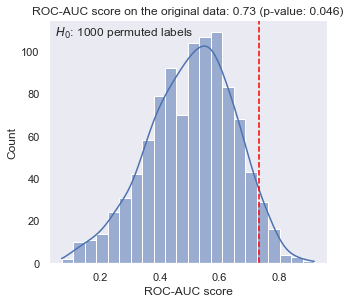

In [273]:
g = sns.displot(perm_scores, kde=True, height=4, aspect=1.2)
g.set(xlabel='ROC-AUC score')

plt.axvline(score_test, ls='--', color='red')
g.set(title=f'ROC-AUC score on the original data: {score_test:.2f} (p-value: {perm_pvalue:.3f})')

g.ax.text(.05,107,'$H_0$: 1000 permuted labels')

plt.show()